In [39]:
%matplotlib inline
import bz2
import json
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import glob

In [97]:
# 12,14,16 are neutrinos.
neutrinos = [12, 14, 16]
labels_ys_cand = [0, 211, 130, 22, 11, 13]

# this is what I can reconstruct
labels_ys_gen = [0, 211, 130, 22, 11, 13]


def prepare_data_clic(fn):

    batched_data = []

    def map_pdgid_to_candid(pdgid, charge):
        if pdgid in [0, 22, 11, 13]:
            return pdgid

        # charged hadron
        if abs(charge) > 0:
            return 211

        # neutral hadron
        return 130

    def track_pt(omega):
        return a * np.abs(b / omega)

    def track_as_array(df_tr, itr):
        row = df_tr.loc[itr]
        return [0, row["px"], row["py"], row["pz"], row["nhits"], row["d0"], row["z0"]]

    def cluster_as_array(df_cl, icl):
        row = df_cl.loc[icl]
        return [1, row["x"], row["y"], row["z"], row["nhits_ecal"], row["nhits_hcal"], row["energy"]]

    def gen_as_array(df_gen, igen):
        if igen:
            row = df_gen.loc[igen]
            return np.array([abs(row["pdgid"]), row["charge"], row["px"], row["py"], row["pz"], row["energy"]])
        else:
            return np.zeros(6)

    def pf_as_array(df_pfs, igen):
        if igen:
            row = df_pfs.loc[igen]
            return np.array([abs(row["type"]), row["charge"], row["px"], row["py"], row["pz"], row["energy"]])
        else:
            return np.zeros(6)

    def filter_gp(gp):
        row = df_gen.loc[gp]
        if row["status"] == 1 and row["energy"] > 0.2:
            return True
        return False

    def flatten_event(df_tr, df_cl, df_gen, df_pfs, pairs):
        Xs = []
        ys_gen = []
        ys_cand = []

        # find all track-associated particles
        for itr in range(len(df_tr)):

            k = ("tr", itr)
            gp = None
            rp = None
            if k in pairs:
                gp = pairs[k][0]
                rp = pairs[k][1]

            # normalize ysgen and yscand
            ys = gen_as_array(df_gen, gp)
            cand = pf_as_array(df_pfs, rp)
            # skip the neutrinos
            if (abs(ys[0]) in neutrinos) or (abs(cand[0]) in neutrinos):
                continue
            else:
                ys[0] = labels_ys_gen.index(map_pdgid_to_candid(abs(ys[0]), ys[-1]))
                cand[0] = labels_ys_cand.index(map_pdgid_to_candid(abs(cand[0]), cand[-1]))
            ys_gen.append(np.delete(ys, -1))
            ys_cand.append(np.delete(cand, -1))
            Xs.append(track_as_array(df_tr, itr))

        # find all cluster-associated particles
        for icl in range(len(df_cl)):

            k = ("cl", icl)
            gp = None
            rp = None
            if k in pairs:
                gp = pairs[k][0]
                rp = pairs[k][1]

            # normalize ysgen and yscand
            ys = gen_as_array(df_gen, gp)
            cand = pf_as_array(df_pfs, rp)
            # skip the neutrinos
            if (abs(ys[0]) in neutrinos) or (abs(cand[0]) in neutrinos):
                continue
            else:
                ys[0] = labels_ys_gen.index(map_pdgid_to_candid(abs(ys[0]), ys[-1]))
                cand[0] = labels_ys_cand.index(map_pdgid_to_candid(abs(cand[0]), cand[-1]))
            # if icl == 5:
            #  print(ys[0], ys[-1])
            ys_gen.append(np.delete(ys, -1))
            ys_cand.append(np.delete(cand, -1))
            Xs.append(cluster_as_array(df_cl, icl))

        Xs = np.stack(Xs, axis=-1).T
        ys_gen = np.stack(ys_gen, axis=-1).T
        # print("ys_gen flatten",ys_gen[:10])
        ys_cand = np.stack(ys_cand, axis=-1).T

        return Xs, ys_gen, ys_cand

    data = json.load(bz2.BZ2File(fn, "r"))
    a = 3 * 10**-4
    b = 5  # B-field in tesla

    ret = []
    for iev in range(len(data)):
        df_gen = pandas.DataFrame(data[iev]["genparticles"])

        # df_hit = pandas.DataFrame(data[iev]["track_hits"])
        df_cl = pandas.DataFrame(data[iev]["clusters"])
        df_tr = pandas.DataFrame(data[iev]["tracks"])
        # df_ecal = pandas.DataFrame(data[iev]["ecal_hits"])
        # df_hcal = pandas.DataFrame(data[iev]["hcal_hits"])
        df_pfs = pandas.DataFrame(data[iev]["pfs"])

        df_tr["pt"] = track_pt(df_tr["omega"])
        df_tr["px"] = np.cos(df_tr["phi"]) * df_tr["pt"]
        df_tr["py"] = np.sin(df_tr["phi"]) * df_tr["pt"]
        df_tr["pz"] = df_tr["tan_lambda"] * df_tr["pt"]

        matrix_tr_to_gp = np.zeros((len(df_tr), len(df_gen)))
        matrix_cl_to_gp = np.zeros((len(df_cl), len(df_gen)))

        for itr in range(len(df_tr)):
            gps = df_tr.loc[itr]["gp_contributions"]
            for gp, val in gps.items():
                matrix_tr_to_gp[itr, int(gp)] += val

        for icl in range(len(df_cl)):
            gps = df_cl.loc[icl]["gp_contributions"]
            for gp, val in gps.items():
                matrix_cl_to_gp[icl, int(gp)] += val

        reco_to_pf = {}
        for ipf in range(len(df_pfs)):
            row = df_pfs.loc[ipf]
            if row["track_idx"] != -1:
                k = ("tr", int(row["track_idx"]))
                assert not (k in reco_to_pf)
                reco_to_pf[k] = ipf
            elif row["cluster_idx"] != -1:
                k = ("cl", int(row["cluster_idx"]))
                assert not (k in reco_to_pf)
                reco_to_pf[k] = ipf
            else:
                # PF should always have a track or a cluster associated
                assert False

        dg = nx.Graph()

        gps = set()

        # loop over clusters, get all genparticles associated to clusters
        for icl in range(len(df_cl)):
            row = df_cl.loc[icl]
            dg.add_node(("cl", icl))
            for gp, weight in row["gp_contributions"].items():
                gp = int(gp)
                if filter_gp(gp):
                    dg.add_node(("gp", gp))
                    gps.add(gp)
                    dg.add_edge(("gp", gp), ("cl", icl), weight=weight)

        # loop over tracks, get all genparticles associated to tracks
        for itr in range(len(df_tr)):
            row = df_tr.loc[itr]
            dg.add_node(("tr", itr))
            for gp in row["gp_contributions"].keys():
                gp = int(gp)
                if filter_gp(gp):
                    dg.add_node(("gp", gp))
                    gps.add(gp)

                    # the track is added to the genparticle with a very high weight
                    # because we always want to associate the genparticle to a track if it's possible
                    dg.add_edge(("gp", gp), ("tr", itr), weight=9999.0)

        # uniqe genparticles
        gps = set(gps)

        # now loop over all the genparticles
        pairs = {}
        for gp in gps:
            gp_node = ("gp", gp)

            # find the neighboring reco elements (clusters and tracks)
            neighbors = list(dg.neighbors(gp_node))
            weights = [dg.edges[gp_node, n]["weight"] for n in neighbors]
            nw = zip(neighbors, weights)

            # sort the neighbors by the edge weight (deposited energy)
            nw = sorted(nw, key=lambda x: x[1], reverse=True)
            reco_obj = None
            if len(nw) > 0:
                # choose the closest neighbor as the "key" reco element
                reco_obj = nw[0][0]

                # remove the reco element from the list, so it can't be associated to anything else
                dg.remove_node(reco_obj)

            # this genparticle had a unique reco element
            if reco_obj:
                pf_obj = None
                if reco_obj and reco_obj in reco_to_pf:
                    pf_obj = reco_to_pf[reco_obj]

                assert not (reco_obj in pairs)
                pairs[reco_obj] = (gp, pf_obj)

            # this is a case where a genparticle did not have a key reco element, but instead was smeared between others
            # else:
            # print("genparticle {} is merged and cannot be reconstructed".format(gp))
            # print(df_gen.loc[gp])

        Xs, ys_gen, ys_cand = flatten_event(df_tr, df_cl, df_gen, df_pfs, pairs)
        ret.append((Xs, ys_gen, ys_cand))
    return ret

In [118]:
ret = []
for fi in list(glob.glob("../data/clic/gev380ee_pythia6_ttbar_rfull201/raw/*.json.bz2"))[:500]:
    ret += prepare_data_clic(fi)

In [120]:
num_elems = [len(r[0]) for r in ret]

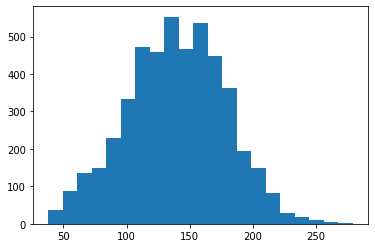

In [123]:
plt.hist(num_elems, bins=21);